## Teste A/B

Teste A/B é uma ferramenta muito poderosa para otimizar um web site. Suponha que você deseja que seus usuários se inscrevam para o seu boletim informativo (newsletter). A chamada à ação do seu site é "Cadastre-se agora!". No entanto, você quer saber se a frase "Cadastre-se hoje!" será mais eficaz. Você mostra sua versão ("Cadastre-se agora!") para alguns de seus usuários e cria uma versão B ("Cadastre-se hoje!"), mostrada a um segundo grupo de usuários. A pergunta que você quer responder é: Deixo minha página como está (ou seja, mantendo a versão A), ou eu mudo para a versão B?

Depois de ter escolhido a métrica que o interessa (no nosso caso, clicando no botão), estimamos as "taxas de conversão" para os grupos A e B, representandos por pA e pB respectivamente, onde pA = (número de conversões no grupo A) / Tamanho do grupo A) e pB = (número de conversões no grupo B) / (tamanho do grupo B). Tenha em mente que estas são meras estimativas das verdadeiras taxas de conversão desconhecidas. Nossas perguntas anteriores se tornam: Qual é a probabilidade de pB ser maior que pA, ou, Prob (pB > pA)? Claro, não podemos pedir a cada pessoa do planeta para para acessar nosso web site. Além disso, a decisão de uma pessoa de clicar em nosso botão pode mudar de um dia para outro. É por isso que contamos com experimentos e estatísticas. O teste estatístico mais direto a ser executado é um teste z. Certamente, para grandes amostras (mais de 1000 visualizações), esta é uma boa abordagem. No entanto, o que acontece se o nosso tamanho da amostra é muito menor do que isso? Ou, se somos obrigados a terminar o nosso teste A/B mais cedo?

É aqui que as estatísticas bayesianas vêm ao nosso resgate. Métodos bayesianos nos permitem incorporar informação prévia ou crenças em nossos modelos, permitindo-nos tomar uma decisão mais bem informada. Esta é a fórmula do Teorema de Bayes, que iremos implementar em Python para analisar o resultado de um Teste A/B.

Basicamente, dizemos que as taxas de conversão têm uma distribuição prévia de uma distribuição beta. Posteriormente, Prob (pB > pA) é calculado como a integral dupla da distribuição conjunta de pA e pB (que, dada a independência, é apenas o produto das distribuições individuais) em que pB > pA. Isso produz esta bela fórmula:

In [1]:
from IPython.display import Image
Image(url = 'assets/formula.png')

In [2]:
from scipy.special import beta
import matplotlib.pyplot as plt
from math import log, exp
from random import random
%matplotlib inline

In [3]:
# Função para simular a geração de um experimento

def generate_one_experiment(total_number_of_visitors, prob_of_showing_version_A, p_A_true, p_B_true):

    size_A = 0
    num_conversions_A = 0
    size_B = 0
    num_conversions_B = 0
    probs_bayesian = [0]*total_number_of_visitors
    probs_bayesian_online = [0]*total_number_of_visitors

    probs_bayesian_online[0] = 0.5

    for j in range(1, total_number_of_visitors):

        visitor = int(random() < prob_of_showing_version_A)

        if visitor:
            size_A += 1
            visitor_converts = int(random() < p_A_true)
            num_conversions_A += visitor_converts
            if visitor_converts:
                changing_variable = 'alpha_A'
            else:
                changing_variable = 'beta_A'
        else:
            size_B += 1
            visitor_converts = int(random() < p_B_true)
            num_conversions_B += visitor_converts
            if visitor_converts:
                changing_variable = 'alpha_B'
            else:
                changing_variable = 'beta_B'

        alpha_A = num_conversions_A + 1
        beta_A = size_A - num_conversions_A + 1
        alpha_B = num_conversions_B + 1
        beta_B = size_B - num_conversions_B + 1

        prob_pB_greater_than_pA_old = probs_bayesian_online[j-1]

        prob_pB_greater_than_pA_bayesian = bayesian_test(alpha_A, beta_A, alpha_B, beta_B)
        prob_pB_greater_than_pA_bayesian_online = bayesian_test_online(alpha_A, beta_A,
              alpha_B, beta_B, prob_pB_greater_than_pA_old, changing_variable)

        probs_bayesian[j] = prob_pB_greater_than_pA_bayesian
        probs_bayesian_online[j] = prob_pB_greater_than_pA_bayesian_online

    return probs_bayesian, probs_bayesian_online


In [4]:
# Função para realizar o teste bayesiano

def bayesian_test(alpha_A, beta_A, alpha_B, beta_B):

    prob_pB_greater_than_pA = 0
    for i in range(0, alpha_B):
        prob_pB_greater_than_pA += exp(log(beta(alpha_A + i, beta_B + beta_A)) - log(beta_B + i) -
                                       log(beta(1 + i, beta_B)) - log(beta(alpha_A, beta_A)))

    return prob_pB_greater_than_pA

In [5]:
# Função para realizar o teste bayesiano online

def bayesian_test_online(alpha_A, beta_A, alpha_B, beta_B, prob_pB_greater_than_pA_old, changing_variable):

    if changing_variable =='alpha_A':
        prob_pB_greater_than_pA = prob_pB_greater_than_pA_old - exp(log(beta(alpha_B + alpha_A - 1, beta_B + beta_A))
                        - log(beta_A + alpha_A - 1) - log(beta(alpha_A, beta_A)) - log(beta(alpha_B, beta_B)))
    if changing_variable =='alpha_B':
        prob_pB_greater_than_pA = prob_pB_greater_than_pA_old + exp(log(beta(alpha_A + alpha_B - 1, beta_B + beta_A))
                        - log(beta_B + alpha_B - 1) - log(beta(alpha_B, beta_B)) - log(beta(alpha_A, beta_A)))
    if changing_variable =='beta_A':
        prob_pB_greater_than_pA = prob_pB_greater_than_pA_old + exp(log(beta(beta_B + beta_A - 1, alpha_B + alpha_A))
                        - log(alpha_A + beta_A - 1) - log(beta(beta_A, alpha_A)) - log(beta(alpha_B, beta_B)))
    if changing_variable =='beta_B':
        prob_pB_greater_than_pA = prob_pB_greater_than_pA_old - exp(log(beta(beta_A + beta_B - 1, alpha_B + alpha_A))
                        - log(alpha_B + beta_B - 1) - log(beta(beta_B, alpha_B)) - log(beta(alpha_A, beta_A)))

    return prob_pB_greater_than_pA

In [6]:
# Definindo as variáveis

total_number_of_visitors = 1000
p_A_true = .2
p_B_true = .3
prob_of_showing_version_A = .5

probs_bayesian, probs_bayesian_online = generate_one_experiment(total_number_of_visitors,
                prob_of_showing_version_A, p_A_true, p_B_true)

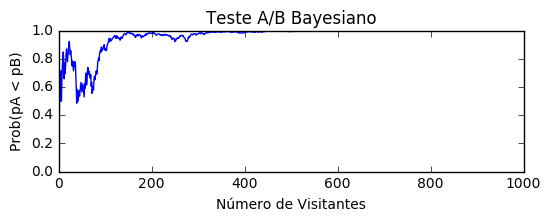

In [7]:
# Plot

plt.figure()

plt.subplot(211)
plt.plot(probs_bayesian)
plt.title('Teste A/B Bayesiano')
plt.ylabel('Prob(pA < pB)')
plt.ylim([0, 1])

#plt.subplot(212)
#plt.plot(probs_bayesian_online, color='red')
#plt.title('Online Bayesian A/B testing')
plt.xlabel('Número de Visitantes')
plt.ylabel('Prob(pA < pB)')
plt.ylim([0, 1])

plt.show()

## Análise

Percebemos que à medida que aumenta o número de visitantes, aumenta consideravelmente a probabilidade de A ser menor que B. Ou seja, a versão B do nosso site terá mais sucesso, gerando mais conversões.